## Street View Housing Number Digit Recognition

In [1]:
import tensorflow as tensorflow
import numpy as np
# pip install matplotlib
# pip install np_utils

### Read the SVHN dataset from the h5py file and understand the train/test splits

#### Loading the dataset

In [2]:
import h5py
h5f = h5py.File('Autonomous_Vehicles_SVHN_single_grey1.h5','r')
h5f.keys()
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val']
y_val = h5f['y_val']
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)
print('X_val',X_val.shape)
print('y_val',y_val.shape)

X_train (42000, 32, 32)
y_train (42000,)
X_test (18000, 32, 32)
y_test (18000,)
X_val (60000, 32, 32)
y_val (60000,)


## Train dataset size: 42k
## Val dataset size: 60k
## Test dataset size: 18k
## Image size: 32x32

In [3]:
X_val = h5f['X_val'][0:8400]
y_val = h5f['y_val'][0:8400]
print('X_val',X_val.shape)
print('y_val',y_val.shape)

X_val (8400, 32, 32)
y_val (8400,)


## Since validation dataset is huge, I am going to use 20% [60k*0.2] of the total validation set to reduce total time taken for validation during training process 

## Reshape and normalize the train and test features

### Convert to 2D tensor: We need to feed a 2D tensor into the model and currently we have a 3D tensor.

In [4]:
X_train = X_train.reshape(42000, 1024)
print(X_train.shape)
X_val = X_val.reshape(8400, 1024)
print(X_val.shape)
X_test = X_test.reshape(18000, 1024)
print(X_test.shape)

(42000, 1024)
(8400, 1024)
(18000, 1024)


### Visualize few samples of training set 

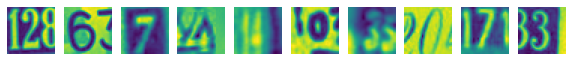

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [5]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(32, 32))
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

### Normalize image pixels from 0:255 Range -> 0:1 Range

In [6]:
# # normalize inputs from 0-255 to 0-1
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test /255.

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(42000,)
(8400,)
(18000,)


## One hot encode the labels for train and test data

In [7]:
print(y_train[0])
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes=10)
print(y_train[0])

2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


#### Define the model architecture using TensorFlow with a flatten layer followed by dense layers with activation as ReLu and softmax

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers, optimizers

### Compile the model with loss as categorical cross-entropy and adam optimizers.

In [9]:
def modeldef_train_and_test_loop(iterations, lr, Lambda, verb=True, graph = False):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    # Normalize the data
    model.add(tensorflow.keras.layers.BatchNormalization())
    # Hidden layers
    model.add(tensorflow.keras.layers.Dense(hidden_nodes, activation='relu', name='Layer_1'))
    model.add(tensorflow.keras.layers.Dense(100, activation='relu', name='Layer_2'))

    # Dropout layer
    model.add(tensorflow.keras.layers.Dropout(0.5))

    # Hidden layers
    model.add(tensorflow.keras.layers.Dense(60, activation='relu', name='Layer_3'))
    model.add(tensorflow.keras.layers.Dense(30, activation='relu', name='Layer_4'))

    # Dropout layer
    model.add(tensorflow.keras.layers.Dropout(0.3))

    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
#     sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit the model
    if(graph == True):
        model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=iterations, batch_size=1000, verbose= 1,callbacks=[plot_losses])
    else:
        model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=iterations, batch_size=1000, verbose= 1)
    
    #,callbacks=[plot_losses]
    score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('test_score',test_score)
    
    return model, test_score

In [10]:
from IPython.display import clear_output

### for printing graphs

In [11]:
class TrainingPlot(tensorflow.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "accuracy")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()


In [12]:
model, bestscore = modeldef_train_and_test_loop(10, 0.1, 0.001, False)

Train on 42000 samples, validate on 8400 samples
Epoch 1/10
42000/42000 [==============================] - 2s 54us/sample - loss: 2.3174 - accuracy: 0.1312 - val_loss: 2.3091 - val_accuracy: 0.0658
Epoch 2/10
42000/42000 [==============================] - 1s 30us/sample - loss: 2.0630 - accuracy: 0.2559 - val_loss: 2.1214 - val_accuracy: 0.5019
Epoch 3/10
42000/42000 [==============================] - 1s 29us/sample - loss: 1.6672 - accuracy: 0.4256 - val_loss: 1.8173 - val_accuracy: 0.5958
Epoch 4/10
42000/42000 [==============================] - 1s 30us/sample - loss: 1.4035 - accuracy: 0.5374 - val_loss: 1.4869 - val_accuracy: 0.6955
Epoch 5/10
42000/42000 [==============================] - 1s 29us/sample - loss: 1.2630 - accuracy: 0.5955 - val_loss: 1.2611 - val_accuracy: 0.7481
Epoch 6/10
42000/42000 [==============================] - 1s 30us/sample - loss: 1.1614 - accuracy: 0.6306 - val_loss: 1.1436 - val_accuracy: 0.7307
Epoch 7/10
42000/42000 [==============================] -

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  4096      
_________________________________________________________________
Layer_1 (Dense)              multiple                  262400    
_________________________________________________________________
Layer_2 (Dense)              multiple                  25700     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
Layer_3 (Dense)              multiple                  6060      
_________________________________________________________________
Layer_4 (Dense)              multiple                  1830      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

### Find the best hyperparameter values for learning rate and Best Lambda for L2 regularization

In [14]:
import math
import numpy as np
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-5.0, 1.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    model,best_acc = modeldef_train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Train on 42000 samples, validate on 8400 samples
Epoch 1/100
42000/42000 [==============================] - 2s 56us/sample - loss: 2.3132 - accuracy: 0.1308 - val_loss: 2.2993 - val_accuracy: 0.0489
Epoch 2/100
42000/42000 [==============================] - 1s 29us/sample - loss: 2.1073 - accuracy: 0.2211 - val_loss: 2.1526 - val_accuracy: 0.3792
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.8209 - accuracy: 0.3471 - val_loss: 1.9431 - val_accuracy: 0.4056
Epoch 4/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.5663 - accuracy: 0.4585 - val_loss: 1.6629 - val_accuracy: 0.6086
Epoch 5/100
42000/42000 [==============================] - 1s 31us/sample - loss: 1.3949 - accuracy: 0.5324 - val_loss: 1.4102 - val_accuracy: 0.6561
Epoch 6/100
42000/42000 [==============================] - 1s 32us/sample - loss: 1.2705 - accuracy: 0.5824 - val_loss: 1.2281 - val_accuracy: 0.6874
Epoch 7/100
42000/42000 [==========================

Epoch 55/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4025 - accuracy: 0.8790 - val_loss: 0.3663 - val_accuracy: 0.9035
Epoch 56/100
42000/42000 [==============================] - 2s 55us/sample - loss: 0.4089 - accuracy: 0.8765 - val_loss: 0.3587 - val_accuracy: 0.9055
Epoch 57/100
42000/42000 [==============================] - 1s 34us/sample - loss: 0.4000 - accuracy: 0.8807 - val_loss: 0.3668 - val_accuracy: 0.9045
Epoch 58/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.3828 - accuracy: 0.8830 - val_loss: 0.3560 - val_accuracy: 0.9044
Epoch 59/100
42000/42000 [==============================] - 1s 32us/sample - loss: 0.3957 - accuracy: 0.8805 - val_loss: 0.3627 - val_accuracy: 0.9042
Epoch 60/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.3882 - accuracy: 0.8837 - val_loss: 0.3632 - val_accuracy: 0.9018
Epoch 61/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.3968 - ac

Epoch 8/100
42000/42000 [==============================] - 1s 33us/sample - loss: 1.0337 - accuracy: 0.6756 - val_loss: 0.8372 - val_accuracy: 0.8087
Epoch 9/100
42000/42000 [==============================] - 2s 53us/sample - loss: 0.9822 - accuracy: 0.6944 - val_loss: 0.8454 - val_accuracy: 0.7774
Epoch 10/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.9244 - accuracy: 0.7168 - val_loss: 0.7102 - val_accuracy: 0.8133
Epoch 11/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.8918 - accuracy: 0.7247 - val_loss: 0.6849 - val_accuracy: 0.8186
Epoch 12/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.8549 - accuracy: 0.7388 - val_loss: 0.6635 - val_accuracy: 0.8264
Epoch 13/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.8129 - accuracy: 0.7508 - val_loss: 0.6328 - val_accuracy: 0.8258
Epoch 14/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.7947 - accu

42000/42000 [==============================] - 1s 29us/sample - loss: 0.7668 - accuracy: 0.7653 - val_loss: 0.6257 - val_accuracy: 0.8340
Epoch 16/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.7578 - accuracy: 0.7676 - val_loss: 0.5885 - val_accuracy: 0.8395
Epoch 17/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.7188 - accuracy: 0.7791 - val_loss: 0.5203 - val_accuracy: 0.8640
Epoch 18/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.7028 - accuracy: 0.7859 - val_loss: 0.5794 - val_accuracy: 0.8395
Epoch 19/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.6734 - accuracy: 0.7962 - val_loss: 0.5587 - val_accuracy: 0.8471
Epoch 20/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.6664 - accuracy: 0.7969 - val_loss: 0.5535 - val_accuracy: 0.8507
Epoch 21/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.6463 - accuracy: 0.804

42000/42000 [==============================] - 1s 29us/sample - loss: 0.6415 - accuracy: 0.8056 - val_loss: 0.5239 - val_accuracy: 0.8521
Epoch 22/100
42000/42000 [==============================] - 2s 41us/sample - loss: 0.6262 - accuracy: 0.8099 - val_loss: 0.4911 - val_accuracy: 0.8643
Epoch 23/100
42000/42000 [==============================] - 2s 44us/sample - loss: 0.6180 - accuracy: 0.8134 - val_loss: 0.4921 - val_accuracy: 0.8646
Epoch 24/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.5994 - accuracy: 0.8192 - val_loss: 0.4692 - val_accuracy: 0.8707
Epoch 25/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.5829 - accuracy: 0.8230 - val_loss: 0.4854 - val_accuracy: 0.8650
Epoch 26/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.5852 - accuracy: 0.8227 - val_loss: 0.4585 - val_accuracy: 0.8752
Epoch 27/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.5674 - accuracy: 0.829

Epoch 28/100
42000/42000 [==============================] - 2s 55us/sample - loss: 0.5978 - accuracy: 0.8219 - val_loss: 0.4764 - val_accuracy: 0.8765- loss: 0.5992 - accuracy: 0.
Epoch 29/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.5814 - accuracy: 0.8227 - val_loss: 0.4750 - val_accuracy: 0.8732
Epoch 30/100
42000/42000 [==============================] - 1s 33us/sample - loss: 0.5793 - accuracy: 0.8254 - val_loss: 0.5040 - val_accuracy: 0.8649
Epoch 31/100
42000/42000 [==============================] - 1s 33us/sample - loss: 0.5643 - accuracy: 0.8321 - val_loss: 0.4724 - val_accuracy: 0.8737
Epoch 32/100
42000/42000 [==============================] - 2s 58us/sample - loss: 0.5581 - accuracy: 0.8312 - val_loss: 0.4490 - val_accuracy: 0.8829
Epoch 33/100
42000/42000 [==============================] - 1s 34us/sample - loss: 0.5518 - accuracy: 0.8337 - val_loss: 0.4176 - val_accuracy: 0.8915
Epoch 34/100
42000/42000 [==============================] - 3s 61

42000/42000 [==============================] - 1s 30us/sample - loss: 0.3375 - accuracy: 0.8998 - val_loss: 0.3406 - val_accuracy: 0.9206
Epoch 83/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.3407 - accuracy: 0.8965 - val_loss: 0.3434 - val_accuracy: 0.9177
Epoch 84/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.3358 - accuracy: 0.8997 - val_loss: 0.3338 - val_accuracy: 0.9219
Epoch 85/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.3333 - accuracy: 0.9001 - val_loss: 0.3360 - val_accuracy: 0.9200
Epoch 86/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.3329 - accuracy: 0.8997 - val_loss: 0.3434 - val_accuracy: 0.9167
Epoch 87/100
42000/42000 [==============================] - 2s 36us/sample - loss: 0.3292 - accuracy: 0.9010 - val_loss: 0.3102 - val_accuracy: 0.9273
Epoch 88/100
42000/42000 [==============================] - 2s 48us/sample - loss: 0.3151 - accuracy: 0.905

42000/42000 [==============================] - 1s 33us/sample - loss: 0.5060 - accuracy: 0.8542 - val_loss: 0.4250 - val_accuracy: 0.8876
Epoch 36/100
42000/42000 [==============================] - 2s 52us/sample - loss: 0.5062 - accuracy: 0.8550 - val_loss: 0.4249 - val_accuracy: 0.8845
Epoch 37/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4854 - accuracy: 0.8590 - val_loss: 0.4109 - val_accuracy: 0.8938
Epoch 38/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4796 - accuracy: 0.8613 - val_loss: 0.4157 - val_accuracy: 0.8930
Epoch 39/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4700 - accuracy: 0.8646 - val_loss: 0.3916 - val_accuracy: 0.9014
Epoch 40/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4697 - accuracy: 0.8653 - val_loss: 0.3916 - val_accuracy: 0.9008
Epoch 41/100
42000/42000 [==============================] - 2s 41us/sample - loss: 0.4517 - accuracy: 0.870

42000/42000 [==============================] - 1s 30us/sample - loss: 0.4747 - accuracy: 0.8555 - val_loss: 0.4131 - val_accuracy: 0.8915
Epoch 43/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4692 - accuracy: 0.8604 - val_loss: 0.4190 - val_accuracy: 0.8930
Epoch 44/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4624 - accuracy: 0.8620 - val_loss: 0.3764 - val_accuracy: 0.9035
Epoch 45/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4621 - accuracy: 0.8618 - val_loss: 0.3964 - val_accuracy: 0.8956
Epoch 46/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4484 - accuracy: 0.8665 - val_loss: 0.3994 - val_accuracy: 0.8961
Epoch 47/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4426 - accuracy: 0.8690 - val_loss: 0.3498 - val_accuracy: 0.9123
Epoch 48/100
42000/42000 [==============================] - 1s 29us/sample - loss: 0.4299 - accuracy: 0.870

42000/42000 [==============================] - 1s 30us/sample - loss: 0.4380 - accuracy: 0.8687 - val_loss: 0.4053 - val_accuracy: 0.8943
Epoch 50/100
42000/42000 [==============================] - 2s 47us/sample - loss: 0.4305 - accuracy: 0.8724 - val_loss: 0.4194 - val_accuracy: 0.8899
Epoch 51/100
42000/42000 [==============================] - 2s 39us/sample - loss: 0.4305 - accuracy: 0.8723 - val_loss: 0.3651 - val_accuracy: 0.9056
Epoch 52/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4228 - accuracy: 0.8760 - val_loss: 0.3807 - val_accuracy: 0.9026
Epoch 53/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4154 - accuracy: 0.8783 - val_loss: 0.3629 - val_accuracy: 0.9079
Epoch 54/100
42000/42000 [==============================] - 1s 31us/sample - loss: 0.4210 - accuracy: 0.8751 - val_loss: 0.3929 - val_accuracy: 0.8996
Epoch 55/100
42000/42000 [==============================] - 1s 30us/sample - loss: 0.4062 - accuracy: 0.880

Epoch 2/100
42000/42000 [==============================] - 1s 29us/sample - loss: 2.1098 - accuracy: 0.2201 - val_loss: 2.1543 - val_accuracy: 0.3861
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.8058 - accuracy: 0.3588 - val_loss: 1.9330 - val_accuracy: 0.4801
Epoch 4/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.5446 - accuracy: 0.4720 - val_loss: 1.6161 - val_accuracy: 0.6051
Epoch 5/100
42000/42000 [==============================] - 1s 29us/sample - loss: 1.3639 - accuracy: 0.5516 - val_loss: 1.3588 - val_accuracy: 0.6788
Epoch 6/100
42000/42000 [==============================] - 1s 29us/sample - loss: 1.2278 - accuracy: 0.6034 - val_loss: 1.2965 - val_accuracy: 0.6738
Epoch 7/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.1472 - accuracy: 0.6345 - val_loss: 1.0074 - val_accuracy: 0.7611
Epoch 8/100
42000/42000 [==============================] - 1s 30us/sample - loss: 1.0584 - accuracy:

## Fit and evaluate the model. Print the loss and accuracy for the test data

### Choose best model try 5 from the above lot as it gives minimim loss and high val accuracy 

42000/42000 [==============================] - 2s 39us/sample - loss: 0.2969 - accuracy: 0.9101 - val_loss: 0.3240 - val_accuracy: 0.9252
test_score [0.557976202537616, 0.8655]
Try 5/100: Best_val_acc: [0.557976202537616, 0.8655], lr: 0.0010950421470782964, Lambda: 6.10775207478701e-06

## Monitor the loss visually,
####  Plot the training loss, validation loss vs number of epochs and training accuracy

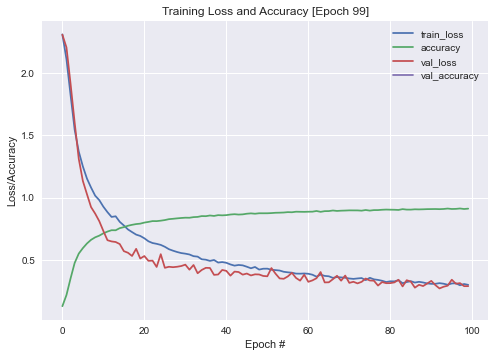

42000/42000 [==============================] - 2s 57us/sample - loss: 0.2983 - accuracy: 0.9111 - val_loss: 0.2879 - val_accuracy: 0.9345
test_score [0.5584547995560699, 0.8637222]


In [21]:
# Try 6/100: Best_val_acc: [0.543610353483094, 0.8661111], lr: 5.3018589037369146e-05, Lambda: 0.004780313883968358
model, bestscore = modeldef_train_and_test_loop(100, 0.075, 4.636865003615338e-05, False, True)

### Observations: from the val_loss and validation accuracy vs number of epochs plot, its visible that the loss curve is slowly going down as and when number of epochs are completed. At the same time accuracy is going up and reaches close to 0.86 which means 86% . We can increase accuracy further by increasing epochs as loss is still going down but it might overfit the model so keeping best model with epoch of 100. Additinally accuracy is not improving much post 100 epochs. So model converges at 100 epochs

In [22]:
model.evaluate(X_test, y_test)

18000/18000 [==============================] - 1s 47us/sample - loss: 0.5585 - accuracy: 0.8637


[0.5584547995560699, 0.8637222]

## Above is best model so far

## try changing a few hyperparameters:such as replace Adam to SGD,  number of layers in the network or number of units in a hidden layer or try different activation functions in the hidden layers

### change optimizer and hidden nodes in dense layers

In [18]:
def train_and_test_loop(iterations, lr, Lambda, verb=True):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    # Normalize the data
    model.add(tensorflow.keras.layers.BatchNormalization())
    # Hidden layers
    model.add(tensorflow.keras.layers.Dense(hidden_nodes, activation='relu', name='Layer_1'))
    model.add(tensorflow.keras.layers.Dense(128, activation='relu', name='Layer_2'))

    # Dropout layer
    model.add(tensorflow.keras.layers.Dropout(0.5))

    # Hidden layers
    model.add(tensorflow.keras.layers.Dense(64, activation='sigmoid', name='Layer_3'))
    model.add(tensorflow.keras.layers.Dense(32, activation='sigmoid', name='Layer_4'))

    # Dropout layer
    model.add(tensorflow.keras.layers.Dropout(0.3))

    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=iterations, batch_size=1000, verbose= 1)
    
    score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('test_score', test_score)
    
    return model, test_score

In [24]:
model, bestscore = train_and_test_loop(100, 0.001, 4.636865003615338e-04, False)

ERROR! Session/line number was not unique in database. History logging moved to new session 774
Train on 42000 samples, validate on 8400 samples
Epoch 1/100
42000/42000 [==============================] - 2s 51us/sample - loss: 2.5080 - accuracy: 0.0992 - val_loss: 2.4966 - val_accuracy: 0.0000e+00
Epoch 2/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.4235 - accuracy: 0.1029 - val_loss: 2.3987 - val_accuracy: 0.0000e+00
Epoch 3/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3900 - accuracy: 0.1016 - val_loss: 2.3550 - val_accuracy: 0.0000e+00
Epoch 4/100
42000/42000 [==============================] - 2s 57us/sample - loss: 2.3762 - accuracy: 0.1027 - val_loss: 2.3350 - val_accuracy: 0.0000e+00
Epoch 5/100
42000/42000 [==============================] - 1s 30us/sample - loss: 2.3706 - accuracy: 0.1037 - val_loss: 2.3252 - val_accuracy: 1.1905e-04
Epoch 6/100
42000/42000 [==============================] - 1s 32us/sample - loss: 2.3

In [25]:
model.evaluate(X_test, y_test)

18000/18000 [==============================] - 1s 49us/sample - loss: 2.2675 - accuracy: 0.2846


[2.267508991241455, 0.2846111]

### by changing activation functions , accuracy seemed to have reduced. Model is not converging. So original model with hyperparameter tuning done earlier is best model

## Result : Validation accuracy - 92 % and More than 86 % accuracy achieved on the test set

## observations
## val vs Test accuracy is 92 /86. Slight variance of 5 to 6% is valid. 
### Best accuracy is achieved with optimizer: Adam and Learning Rate:  0.075 and
lambda = 4.636865003615338e-05
### leraning rate Decay - 1E-6
### Drop out with probability < 0.5 dropped to reduce overfit in the model